# Test Gaussian anamorphosis with lognormal distribution

TODO: reporduce this in RGeostat to check for errors

A fluctuation in pygslib.nonlinear.Y2Z vs raw input is observed. This may be related to inconsistencies of the PCI. 

In [1]:
import pygslib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
# create a dataset with known underlying gaussian distribution
gaussian_mean = 0
gaussian_sigma= 1

#generate a glognormal sample
log_db = np.random.lognormal(gaussian_mean, gaussian_sigma, size=1000)
log_cdf = np.sort(log_db) # the cdf

# the back transform using gslib nscore
raw_db, norm_db = pygslib.nonlinear.ttable(log_db, log_db*0+1)


#actual moments (see https://en.wikipedia.org/wiki/Log-normal_distribution)
actual_mean = np.exp(gaussian_mean + 0.5*(gaussian_sigma**2))
actual_var = (np.exp(gaussian_sigma**2)-1)*np.exp(2*gaussian_mean+gaussian_sigma**2)

In [3]:
# calculate bootstrap stats and compare with actual stats
bst_mean = []
bst_var = []
sample_size = 1000
iterations = 1000
replacement = True
for i in range(iterations):
    tmp = np.random.choice(log_db, size=sample_size, replace=replacement)
    bst_mean.append(np.mean(tmp))
    bst_var.append(np.var(tmp))
    
print (" actual mean {:.2f}\n".format(actual_mean), 
       "experimental mean {:.2f}\n".format(np.mean(log_db)), 
       "bootstrap mean {:.2f}".format(np.mean(bst_mean)))
print (" actual var {:.2f}\n".format(actual_var), 
       "experimental var {:.2f}\n".format(np.var(log_db)), 
       "bootstrap var {:.2f}".format(np.mean(bst_var)))


 actual mean 1.65
 experimental mean 1.61
 bootstrap mean 1.61
 actual var 4.67
 experimental var 3.32
 bootstrap var 3.32


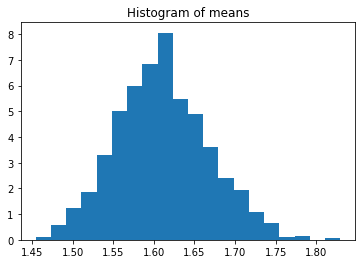

In [4]:
plt.hist(bst_mean, density = True, bins = 20);
plt.title('Histogram of means');

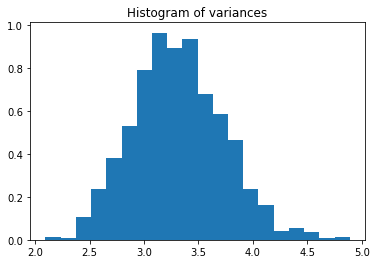

In [5]:
plt.hist(bst_var, density = True, bins = 20);
plt.title('Histogram of variances');

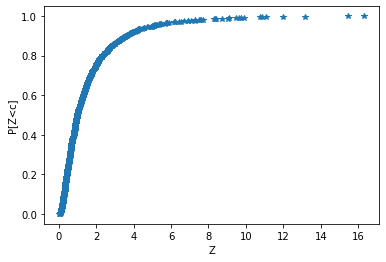

In [6]:
# plot the CDF
plt.plot(log_cdf,np.arange(log_cdf.shape[0])/log_cdf.shape[0], '*');
plt.xlabel('Z')
plt.ylabel('P[Z<c]')
plt.show()

('Raw Variance', 3.3214335720355113)
('Variance from PCI', 3.3112678391783623)
('zamin', 0.09172570085631224)
('zamax', 16.292692017380286)
('yamin', -2.5028904219737456)
('yamax', 3.256699338207537)
('zpmin', 0.03939770629792922)
('zpmax', 16.29303020032258)
('ypmin', -3.290395004796649)
('ypmax', 3.2903950047966495)


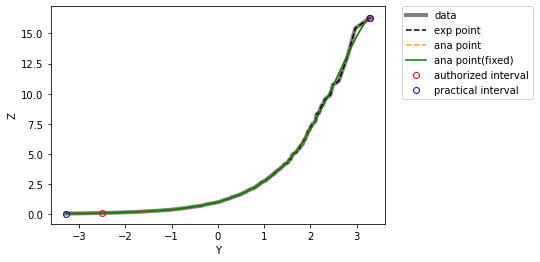

In [25]:
# get the anamorphosis
PCI, H, raw, zana, gauss, Z, P, raw_var , PCI_var, \
fig, zamin, zamax, yamin, yamax, zpmin, zpmax, ypmin, ypmax = pygslib.nonlinear.anamor(
                         z = log_db, w = log_db*0 + 1, ltail=1, utail=1, ltpar=1, utpar=1, K=30, 
                         zmin=None, zmax=None, ymin=None, ymax=None,
                         zamin=None, zamax=None, zpmin=None, zpmax=None,
                         ndisc = 50000)

In [26]:
# get distribution back from PCI
log_db_baktr = pygslib.nonlinear.Y2Z(y = norm_db, 
                      PCI = PCI, 
                      zamin = zamin, 
                      yamin = yamin, 
                      zpmin = zpmin, #zpmin,
                      ypmin = ypmin, 
                      zpmax = zpmax, #zpmax, 
                      ypmax = ypmax,
                      zamax = zamax, 
                      yamax = yamax,
                      r=1)
# get lognormal data again
gau_db_baktr =  pygslib.nonlinear.Z2Y_linear(z = log_db_baktr,
                      zm = raw_db, 
                      ym = norm_db,
                      zamin = zamin, 
                      yamin = yamin, 
                      zpmin = zpmin, 
                      ypmin = ypmin, 
                      zpmax = zpmax, 
                      ypmax = ypmax,
                      zamax = zamax, 
                      yamax = yamax)

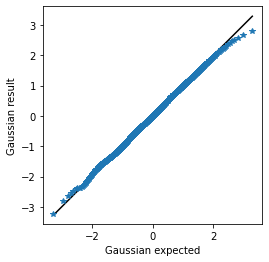

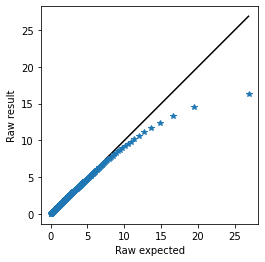

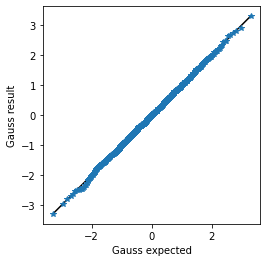

In [27]:
# plot the results
mx = max(max(norm_db), max(np.log(log_db_baktr)))
mi = max(min(norm_db), min(np.log(log_db_baktr)))

# plot normal data vs back transf in normal space
plt.plot([mi,mx], [mi,mx], '-k')
plt.plot(norm_db, np.log(log_db_baktr), '*')
plt.xlabel('Gaussian expected')
plt.ylabel('Gaussian result')
plt.axis('scaled')
plt.show()

# plot normal data vs back transf in raw space
plt.plot(np.exp([mi,mx]), np.exp([mi,mx]), '-k')
plt.plot(np.exp(norm_db), log_db_baktr, '*')
plt.xlabel('Raw expected')
plt.ylabel('Raw result')
plt.axis('scaled')
plt.show()

# extra plot to test pygslib.nonlinear.Z2Y_linear
plt.plot([mi,mx], [mi,mx], '-k')
plt.plot(norm_db, gau_db_baktr, '*')
plt.xlabel('Gauss expected')
plt.ylabel('Gauss result')
plt.axis('scaled')
plt.show()

In [28]:
print (" zamin {:.2f}\n".format(zamin), 
      "yamin {:.2f}\n".format(yamin), 
      "zpmin {:.2f}\n".format(zpmin),
      "ypmin {:.2f}\n".format(ypmin), 
      "zpmax {:.2f}\n".format(zpmax), 
      "ypmax {:.2f}\n".format(ypmax),
      "zamax {:.2f}\n".format(zamax), 
      "yamax {:.2f}\n".format(yamax),)

 zamin 0.09
 yamin -2.50
 zpmin 0.04
 ypmin -3.29
 zpmax 16.29
 ypmax 3.29
 zamax 16.29
 yamax 3.26



# Distribution of the residuals

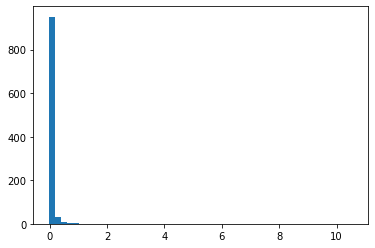

In [29]:
#mask = (log_db_baktr>zamin) &  (log_db_baktr<zamax)
plt.hist(np.exp(norm_db) - log_db_baktr, bins = 50); 

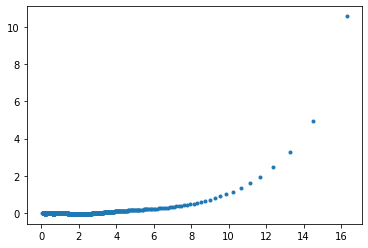

In [30]:
plt.plot(log_db_baktr, (np.exp(norm_db) - log_db_baktr), '.');